In [1]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.retrievers import BM25Retriever, EnsembleRetriever
import pickle
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("Langgraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
Langgraph


In [3]:
with open("outputs/split_documents.pkl", "rb") as f:
    split_documents = pickle.load(f)

In [4]:
vectorstore = FAISS.load_local(
    "faiss_index", 
    OpenAIEmbeddings(),
    allow_dangerous_deserialization=True  # needed in newer versions
)

In [5]:
faiss_retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

In [6]:
bm25_retriever = BM25Retriever.from_documents(
    split_documents,
)
bm25_retriever.k = 1

In [7]:
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever],
    weights=[0.7, 0.3],
)

In [8]:
# 검색 결과 문서를 가져옵니다.
query = "what are risks and challenges of Korea in global economy?"
ensemble_result = ensemble_retriever.invoke(query)
bm25_result = bm25_retriever.invoke(query)
faiss_result = faiss_retriever.invoke(query)

# 가져온 문서를 출력합니다.
print("[Ensemble Retriever]")
for doc in ensemble_result:
    print(f"Content: {doc.page_content}")
    print()

print("[BM25 Retriever]")
for doc in bm25_result:
    print(f"Content: {doc.page_content}")
    print()

print("[FAISS Retriever]")
for doc in faiss_result:
    print(f"Content: {doc.page_content}")
    print()

[Ensemble Retriever]
Content: 27. Stretched valuations in financial markets, including the rapid growth in crypto-asset market  
capitalisation, and the growing interconnections between banks and non-bank financial institutions call for  
enhanced vigilance to safeguard financial stability. Effective monitoring, supervision and robust regulatory  
policies are needed, particularly of potential liquidity mismatches and leverage risks for non-bank financial  
institutions, in line with internationally-recommended norms. Enhancing reporting requirements and filling  
data gaps would improve the monitoring of risks and help relevant authorities mitigate financial  
vulnerabilities and prepare for possible future corrections in asset prices that would have systemic  
consequences. While crypto-assets share some characteristics with traditional financial products, they  
present a unique set of policy challenges given their borderless and pseudonymous nature. Countries

Content: 32. Recent e

In [9]:
ensemble_result

[Document(metadata={'page': 21, 'image_id': [168], 'image_path': ['/images/sample_cropped_chart_168.png'], 'text_summary': [], 'image_summary': 'Here’s a description of the image and what it shows.\n\nWhat the image is\n- Figure 10: “Policy rates are expected to ease gradually.”\n- It contains two line charts side by side:\n  - Panel A: Advanced economies\n  - Panel B: Emerging-market economies\n- Each panel shows policy interest rates (percent) over time, from about 2022 through 2026.\n- Colors represent different countries:\n  - Panel A (Advanced economies): United States (red), United Kingdom (orange), Euro area (blue), Japan (green).\n  - Panel B (Emerging markets): Brazil (red), India (blue), Mexico (green), South Africa (orange).\n- The note under Panel A explains that it shows the midpoint of the US federal funds target range and the euro area deposit facility rate.\n- The source is the OECD Interim Economic Outlook database (OECD 2025).\n\nWhat the charts convey\n- The headline

In [10]:
from langchain.schema import Document
def format_context(results: list[Document]) -> str:
    arr = []
    for i, doc in enumerate(results):
        text = f"""Retrieved #{i+1}
                    {doc.page_content}
                    {doc.metadata['text_summary'] if len(doc.metadata['text_summary']) > 0 else ''}
                    {doc.metadata['image_summary'] if len(doc.metadata['image_summary']) > 0 else ''}
                """
        arr.append(text)
    return "\n".join(arr)

In [11]:
format_context(ensemble_result)

'Retrieved #1\n                    27. Stretched valuations in financial markets, including the rapid growth in crypto-asset market  \ncapitalisation, and the growing interconnections between banks and non-bank financial institutions call for  \nenhanced vigilance to safeguard financial stability. Effective monitoring, supervision and robust regulatory  \npolicies are needed, particularly of potential liquidity mismatches and leverage risks for non-bank financial  \ninstitutions, in line with internationally-recommended norms. Enhancing reporting requirements and filling  \ndata gaps would improve the monitoring of risks and help relevant authorities mitigate financial  \nvulnerabilities and prepare for possible future corrections in asset prices that would have systemic  \nconsequences. While crypto-assets share some characteristics with traditional financial products, they  \npresent a unique set of policy challenges given their borderless and pseudonymous nature. Countries\n        

In [12]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

In [13]:
# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = ensemble_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    context = format_context(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return {"context": context}


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]
   
    llm = ChatOpenAI(model_name="gpt-5-mini", temperature=0)
      
    system_prompt = """You are an assistant for question-answering tasks. 
        Use the following pieces of retrieved context to answer the question. 
        If you don't know the answer, just say that you don't know. 
        Answer in Korean.
    """
    
    prompt = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": "Context: " + context},
        {"role": "user", "content": "Question: " + latest_question},
    ]
        
    # 체인을 호출하여 답변을 생성합니다.
    response = llm.invoke(prompt)
    print("response", response)
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return {
        "answer": response.content,
        "messages": [("user", latest_question), ("assistant", response.content)],
    }

In [14]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

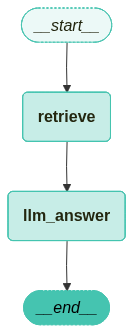

In [15]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [16]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid
inputs = GraphState(question="한국이 직면한 위기와 도전을 알려주세요.")
# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 1})

In [17]:
result = app.invoke(inputs, config=config)


response content='제공된 자료(경제전망 중간보고서)에 근거해 한국이 직면한 주요 위기와 도전은 다음과 같습니다.\n\n- 교역·무역 충격 위험  \n  - 보고서는 각국이 글로벌 무역체제 내에서 협력하고 무역정책의 투명성과 예측가능성을 높여야 한다고 강조합니다. 수출비중이 큰 한국은 보호무역·공급망 충격 등에 취약합니다.\n\n- 물가·통화정책의 딜레마  \n  - 물가가 완화될 경우 기준금리를 완화할 여지가 있지만(물가기대가 잘 고정돼 있을 때), 중앙은행은 여전히 경계 상태를 유지해야 한다고 합니다. 한국은행은 성장·금융안정과 물가 관리 사이에서 균형을 유지해야 하는 도전에 직면해 있습니다.\n\n- 재정건전성 문제  \n  - 장기적 채무지속가능성을 지키기 위한 재정 규율이 필요하다는 점이 강조됩니다. 경기충격에 대응할 여력을 남기려면 재정정책 운용에서 신중함이 요구됩니다.\n\n- 구조개혁·생산성 제고  \n  - 생활수준 향상과 인공지능(AI) 등 신기술의 잠재력 실현을 위해 강화된 구조개혁이 필요합니다. 노동시장·혁신체계·규제개선 등이 과제로 남아 있습니다.\n\n- 금융안정 리스크 확대  \n  - 자산가치의 고평가(특히 기술주 집중)와 이에 따른 급격한 리프라이싱 가능성은 금융시장 변동성을 키웁니다. 이런 충격은 한국의 주식시장·연계 펀드 등에 전이될 수 있습니다.\n\n- 비(非)은행 금융과 암호자산 관련 리스크  \n  - 비은행 금융중개기관의 급성장, 그리고 암호자산(시장규모가 급증한 점)은 시스템 리스크와 상호연계 위험을 높입니다. 스테이블코인 등은 가치 스트레스 시 뱅크런과 유사한 불안정을 유발할 수 있어 주의가 필요합니다.\n\n요약하면, 한국은 대외충격·무역 불확실성, 물가와 통화정책의 균형, 재정지속가능성, 구조개혁 필요성, 그리고 자산높은 밸류에이션과 암호자산·비은행금융의 확대로 인한 금융안정 리스크라는 복합적 도전에 직면해 있습니다. 대응으로는 국제협력 강화, 통화·재정의 신중한 운영, 금융감독 강화 및 구조개혁 

In [18]:
result['answer']

'제공된 자료(경제전망 중간보고서)에 근거해 한국이 직면한 주요 위기와 도전은 다음과 같습니다.\n\n- 교역·무역 충격 위험  \n  - 보고서는 각국이 글로벌 무역체제 내에서 협력하고 무역정책의 투명성과 예측가능성을 높여야 한다고 강조합니다. 수출비중이 큰 한국은 보호무역·공급망 충격 등에 취약합니다.\n\n- 물가·통화정책의 딜레마  \n  - 물가가 완화될 경우 기준금리를 완화할 여지가 있지만(물가기대가 잘 고정돼 있을 때), 중앙은행은 여전히 경계 상태를 유지해야 한다고 합니다. 한국은행은 성장·금융안정과 물가 관리 사이에서 균형을 유지해야 하는 도전에 직면해 있습니다.\n\n- 재정건전성 문제  \n  - 장기적 채무지속가능성을 지키기 위한 재정 규율이 필요하다는 점이 강조됩니다. 경기충격에 대응할 여력을 남기려면 재정정책 운용에서 신중함이 요구됩니다.\n\n- 구조개혁·생산성 제고  \n  - 생활수준 향상과 인공지능(AI) 등 신기술의 잠재력 실현을 위해 강화된 구조개혁이 필요합니다. 노동시장·혁신체계·규제개선 등이 과제로 남아 있습니다.\n\n- 금융안정 리스크 확대  \n  - 자산가치의 고평가(특히 기술주 집중)와 이에 따른 급격한 리프라이싱 가능성은 금융시장 변동성을 키웁니다. 이런 충격은 한국의 주식시장·연계 펀드 등에 전이될 수 있습니다.\n\n- 비(非)은행 금융과 암호자산 관련 리스크  \n  - 비은행 금융중개기관의 급성장, 그리고 암호자산(시장규모가 급증한 점)은 시스템 리스크와 상호연계 위험을 높입니다. 스테이블코인 등은 가치 스트레스 시 뱅크런과 유사한 불안정을 유발할 수 있어 주의가 필요합니다.\n\n요약하면, 한국은 대외충격·무역 불확실성, 물가와 통화정책의 균형, 재정지속가능성, 구조개혁 필요성, 그리고 자산높은 밸류에이션과 암호자산·비은행금융의 확대로 인한 금융안정 리스크라는 복합적 도전에 직면해 있습니다. 대응으로는 국제협력 강화, 통화·재정의 신중한 운영, 금융감독 강화 및 구조개혁 추진이 요구됩니다.'

In [19]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="터키가 직면한 위기와 도전을 알려주세요.")

# 그래프 실행
invoke_graph(app, inputs, config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
Retrieved #1
                    The Interim Report says that countries need to find ways of engaging co‑operatively within the global trading system  
and working together to make trade policy more transparent and predictable. Central banks should remain vigilant, but  
can lower policy interest rates where underlying inflation is projected to moderate towards target, provided inflation  
expectations remain well anchored. Fiscal discipline is needed to safeguard longer‑term debt sustainability and allow  
governments to react to future shocks. Enhanced structural reform efforts are required to durably improve living  
standards and help realise the potential from new technologies, such as artificial intelligence.

  

The Interim Report is an update on the assessment in the June 2025 of the Economic Outlook (Volume 2025 Issue 1).

PDF ISBN 978-92-64-57606-3

  

9HSTCQE\*fhgagd+
                    
     

In [20]:
for event in app.stream(inputs, config=config, stream_mode="updates"):
    for value in event.values():
        print(value)

{'context': 'Retrieved #1\n                    The Interim Report says that countries need to find ways of engaging co‑operatively within the global trading system  \nand working together to make trade policy more transparent and predictable. Central banks should remain vigilant, but  \ncan lower policy interest rates where underlying inflation is projected to moderate towards target, provided inflation  \nexpectations remain well anchored. Fiscal discipline is needed to safeguard longer‑term debt sustainability and allow  \ngovernments to react to future shocks. Enhanced structural reform efforts are required to durably improve living  \nstandards and help realise the potential from new technologies, such as artificial intelligence.\n\n  \n\nThe Interim Report is an update on the assessment in the June 2025 of the Economic Outlook (Volume 2025 Issue 1).\n\nPDF ISBN 978-92-64-57606-3\n\n  \n\n9HSTCQE\\*fhgagd+\n                    \n                    \n                \nRetrieved #2\